In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [5]:
import pathlib

data_dir = pathlib.Path('Fish_Dataset')



In [7]:
image_count = len(list(data_dir.glob(r'**/*.png')))
print(image_count)


18000


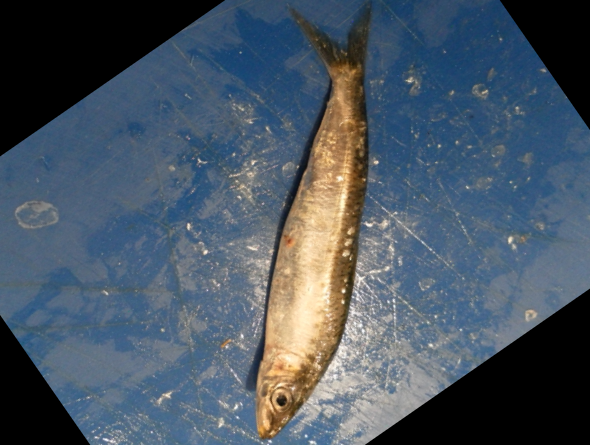

In [10]:
bss = list(data_dir.glob('Black Sea Sprat/Black Sea Sprat/*'))
PIL.Image.open(str(bss[0]))


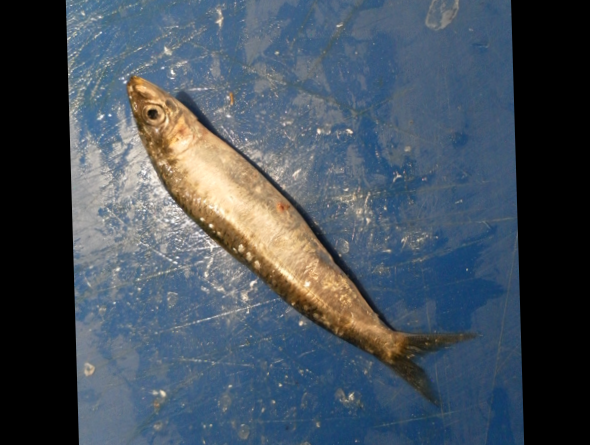

In [13]:
PIL.Image.open(str(bss[1]))


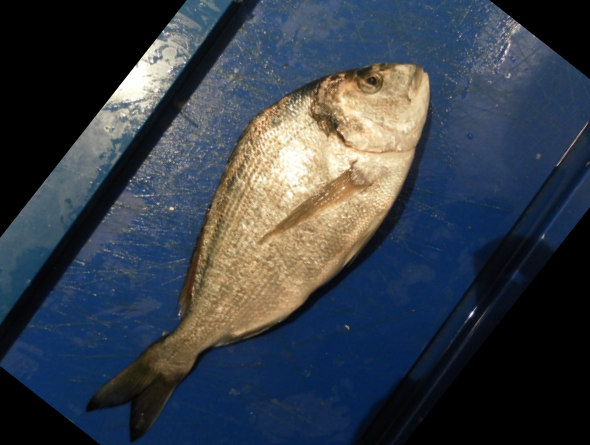

In [15]:
ghb = list(data_dir.glob('Gilt-Head Bream/Gilt-Head Bream/*'))
PIL.Image.open(str(ghb[0]))

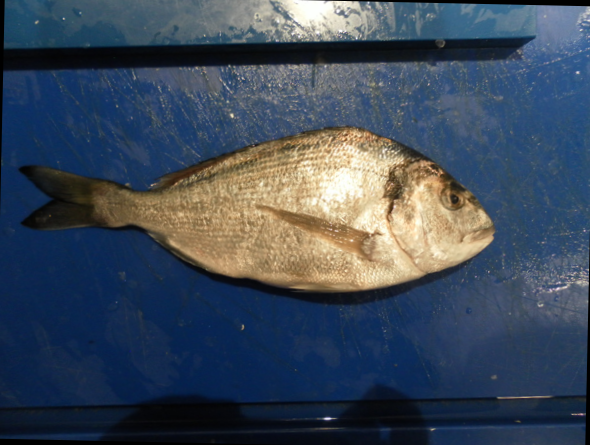

In [16]:
PIL.Image.open(str(ghb[1]))

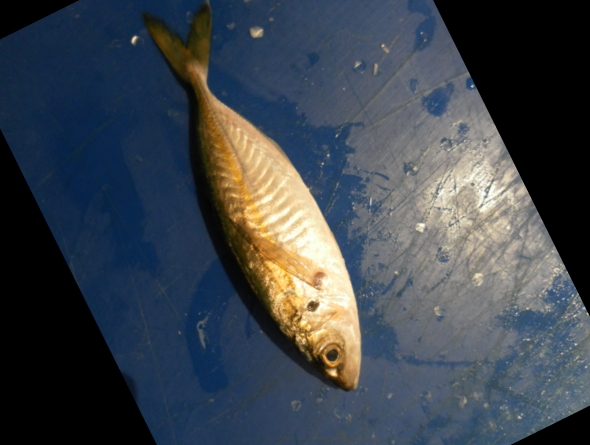

In [18]:
hm = list(data_dir.glob('Hourse Mackerel/Hourse Mackerel/*'))
PIL.Image.open(str(hm[0]))

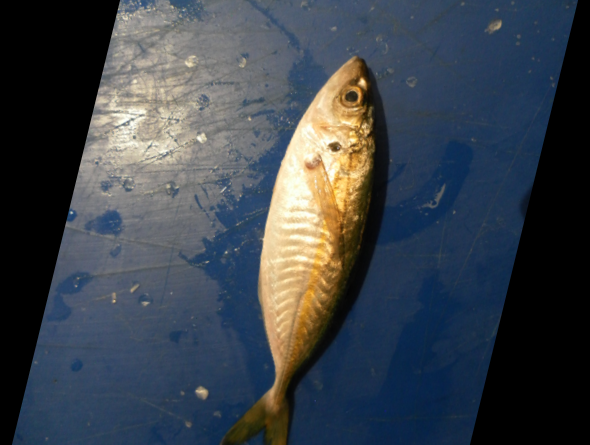

In [19]:
PIL.Image.open(str(hm[1]))

dataset creation

In [20]:
batch_size = 32
img_height = 224
img_width = 224


In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)


['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


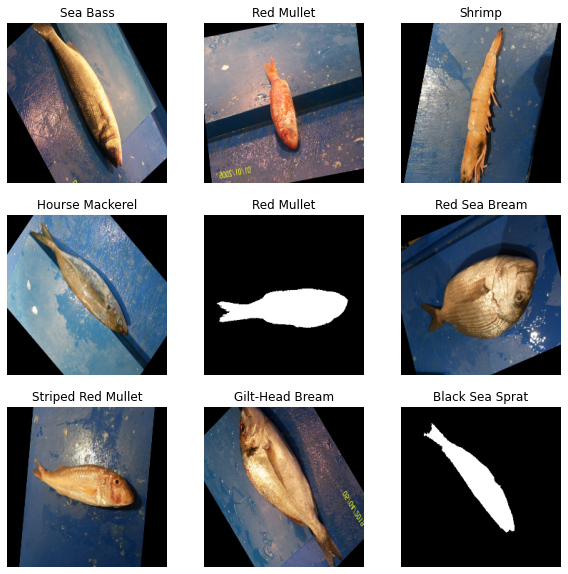

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


dataset configuration for performance

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [30]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [32]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


compilation


In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

model training


In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
450/450 [==============================] - 681s 2s/step - loss: 1.4451 - accuracy: 0.4669 - val_loss: 0.6454 - val_accuracy: 0.7628
Epoch 2/10
450/450 [==============================] - 609s 1s/step - loss: 0.4329 - accuracy: 0.8423 - val_loss: 0.5645 - val_accuracy: 0.8039
Epoch 3/10
450/450 [==============================] - 495s 1s/step - loss: 0.1977 - accuracy: 0.9331 - val_loss: 0.6032 - val_accuracy: 0.8272
Epoch 4/10
450/450 [==============================] - 516s 1s/step - loss: 0.0921 - accuracy: 0.9701 - val_loss: 0.6619 - val_accuracy: 0.8333
Epoch 5/10
450/450 [==============================] - 477s 1s/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.7199 - val_accuracy: 0.8344
Epoch 6/10
450/450 [==============================] - 474s 1s/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.8438 - val_accuracy: 0.8189
Epoch 7/10
450/450 [==============================] - 488s 1s/step - loss: 0.0281 - accuracy: 0.9925 - val_loss: 0.8800 - val_accuracy: 0.8347

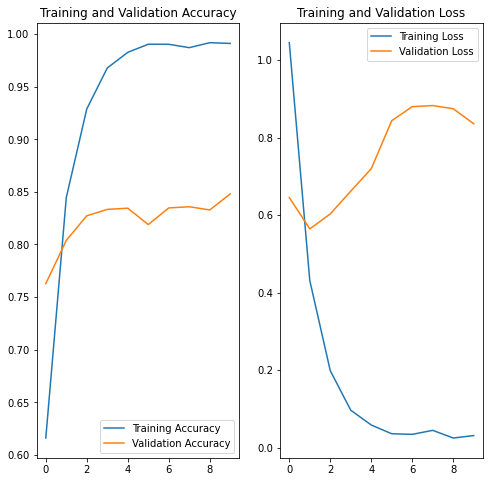

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [37]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


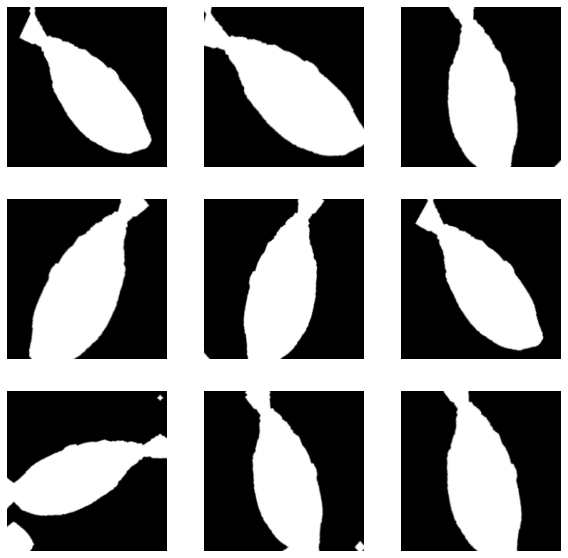

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [39]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [41]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

In [42]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
450/450 [==============================] - 808s 2s/step - loss: 1.6980 - accuracy: 0.3498 - val_loss: 1.0924 - val_accuracy: 0.5850
Epoch 2/15
450/450 [==============================] - 538s 1s/step - loss: 1.0042 - accuracy: 0.6075 - val_loss: 0.8403 - val_accuracy: 0.6844
Epoch 3/15
450/450 [==============================] - 521s 1s/step - loss: 0.8216 - accuracy: 0.6794 - val_loss: 0.6990 - val_accuracy: 0.7469
Epoch 4/15
450/450 [==============================] - 1395s 3s/step - loss: 0.7165 - accuracy: 0.7292 - val_loss: 0.7126 - val_accuracy: 0.7431
Epoch 5/15
450/450 [==============================] - 832s 2s/step - loss: 0.5989 - accuracy: 0.7684 - val_loss: 1.6719 - val_accuracy: 0.6011
Epoch 6/15
450/450 [==============================] - 537s 1s/step - loss: 0.5512 - accuracy: 0.7873 - val_loss: 0.5596 - val_accuracy: 0.7933
Epoch 7/15
450/450 [==============================] - 542s 1s/step - loss: 0.5160 - accuracy: 0.8047 - val_loss: 1.3261 - val_accuracy: 0.648

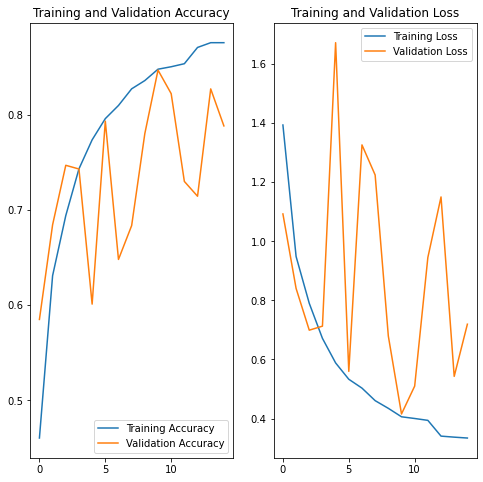

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [50]:
mullet_url = "https://seafoodacademy.org/img/topic-91-notes-image2.jpg"
mullet_path = tf.keras.utils.get_file('redmullet', origin=mullet_url)

img = keras.preprocessing.image.load_img(
    mullet_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Red Mullet with a 100.00 percent confidence.
